In [1]:
import anndata as ad
import re
import os
import scipy.stats as st
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append(os.getcwd())

from GLOBAL_VARIABLES.GLOBAL_VARIABLES import cc_mapping_package_dir
sys.path.append(cc_mapping_package_dir)

from cc_mapping import preprocess
from cc_mapping import core
from cc_mapping import manifold

In [3]:
cell_line = 'CFPAC'
main_dir = "C:/Users/dap182/Documents/Stallaert_lab/PDAC_pipeline"

data_dir = f'{main_dir}/data'
data_file = f'{data_dir}/{cell_line}/{cell_line}.h5ad'

adata = ad.read_h5ad(data_file)

In [4]:
#ensure that cells can be identified after filtering
#This data contains all CFPAC cells, if you split the data and then save it. Do not change the CellID
adata.obs['CellID'] = adata.obs.index

In [5]:
#ensure that the adata.var_names are the features of the dataset
adata.var_names = adata.var['X_features']

In [6]:
#isolates diploid cells from the dataset using the adata.obs['genome'] column
adata = preprocess.row_data_partitioning(adata, search_str = 'diploid', search_obs = 'genome')

In [7]:
#optional: you can add a custom feature set by adding it to adata.var 

#creates a smaller training feature set for random forest
regex='((Std_PCNA|Intg_DNA|over_|Med_).*(nuc))|((AreaShape_Area).*(nuc|cell))'
training_features =  [feat for feat in adata.var_names if re.search(regex, feat) != None]

#runs random forest for feature selection
adata = core.random_forest_feature_selection(adata, training_features, training_labels = 'phase', method = 'RF_min_max')

Generating hyperparameter search plots: 100%|██████████| 2/2 [02:59<00:00, 89.62s/it]


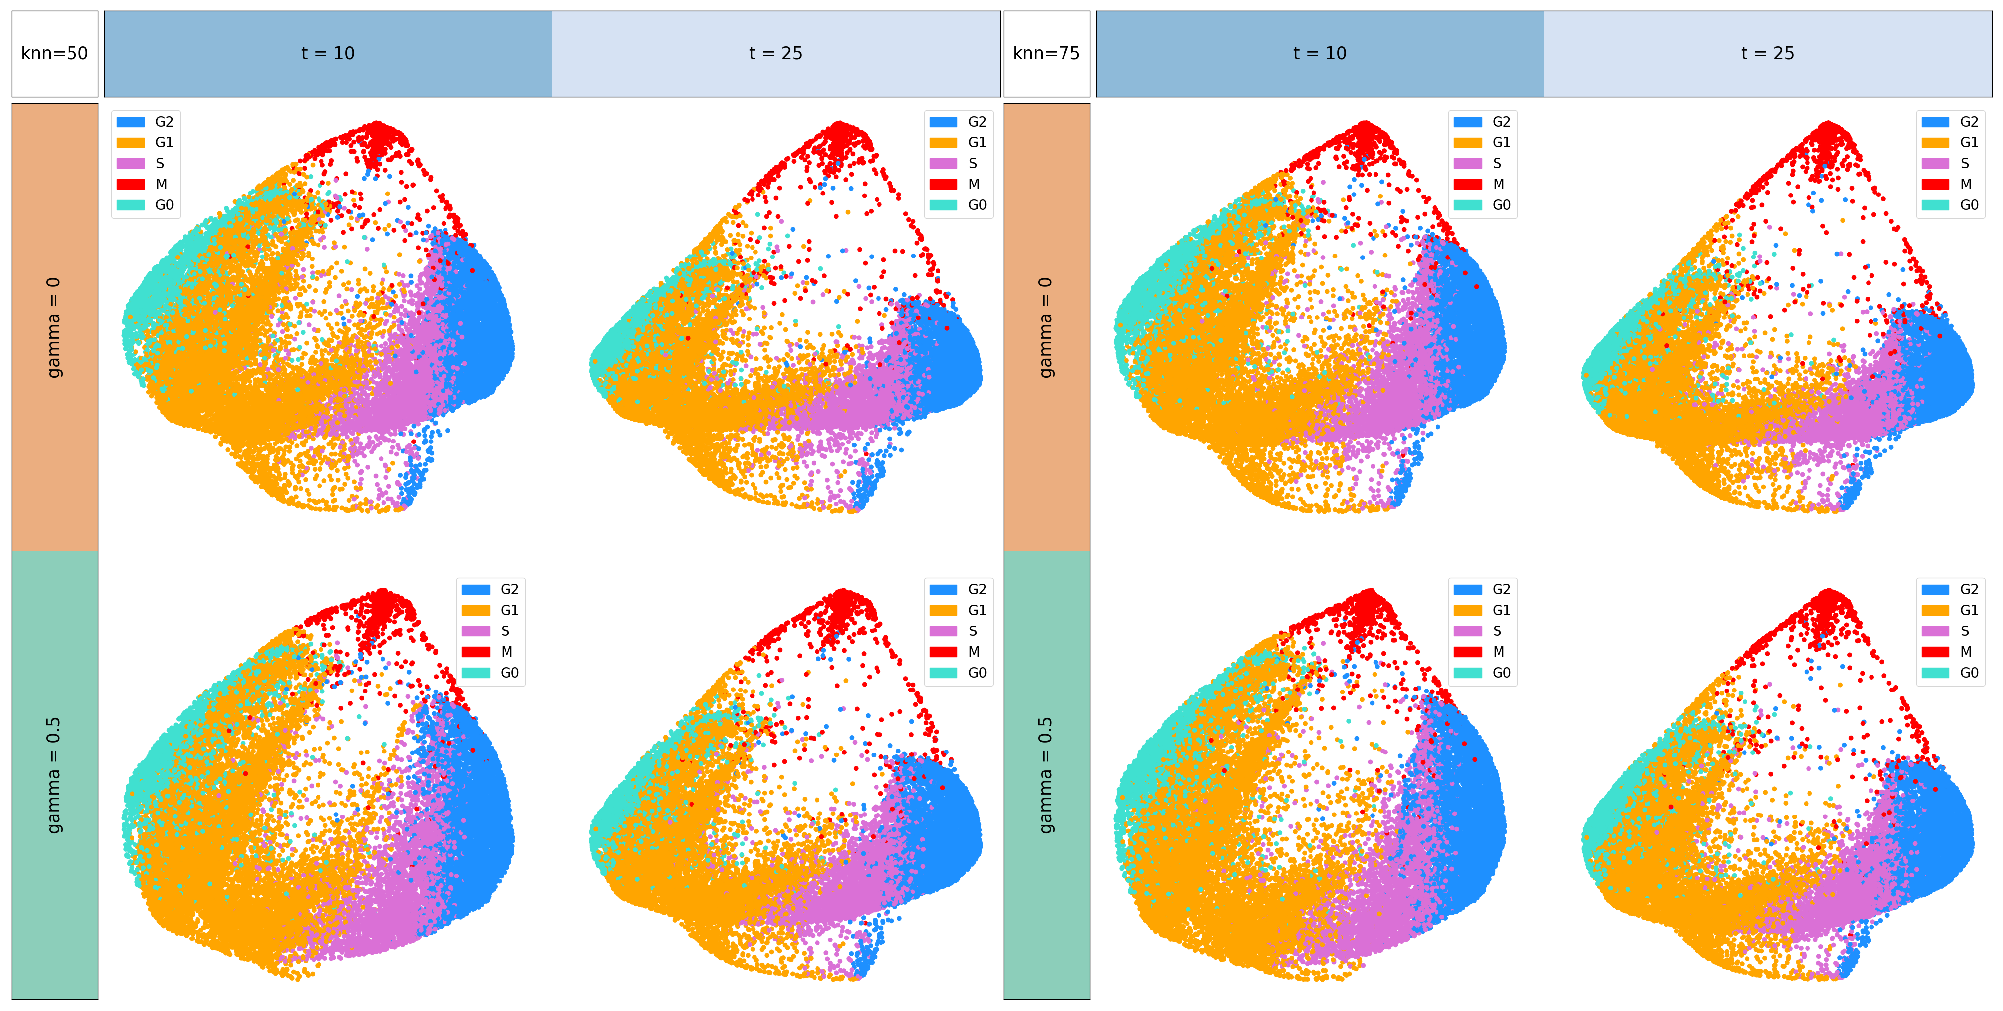

<Axes: >

In [8]:
phate_param_dict = {'n_components': 2,
                    'knn': [50,75],
                    'gamma': [0,0.5],
                    't': [10,25],
                    'n_jobs': -1,
                    'random_state': 0,
                    'verbose': 0}

param_info_dict = { 'row_label': 'gamma',
                    'col_label': 't',
                    'constant_label': 'knn',
                    'final_figure_dims': (1,2)}

manifold.perform_phate_hyperparameter_search(adata,
                                        feature_set = 'RF_min_max_feature_set',
                                        hyperparam_dict = phate_param_dict,
                                        hyperparam_info_dict = param_info_dict,
                                        color_name= 'phase_colors',
                                        norm_method= 'z_score',
                                        save_path = f'.\{cell_line}_hyperparameter_search.png',)

In [9]:
phate_optimal_parameter_dict = {'t': 50 , 'gamma': 1 , 'knn': 75, 'random_state': 0}

adata = manifold.run_phate(adata, 
                           feature_set = 'RF_min_max_feature_set', 
                           phate_param_dict = phate_optimal_parameter_dict,
                           norm_method = 'z_score',
                           obsm_save_key = 'X_phate')

Calculating PHATE...
  Running PHATE on 24219 observations and 15 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


    Calculated KNN search in 13.61 seconds.
    Calculating affinities...
    Calculated affinities in 0.79 seconds.
  Calculated graph and diffusion operator in 14.53 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.96 seconds.
  Calculated landmark operator in 11.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.22 seconds.
Calculated PHATE in 29.69 seconds.


<Axes: >

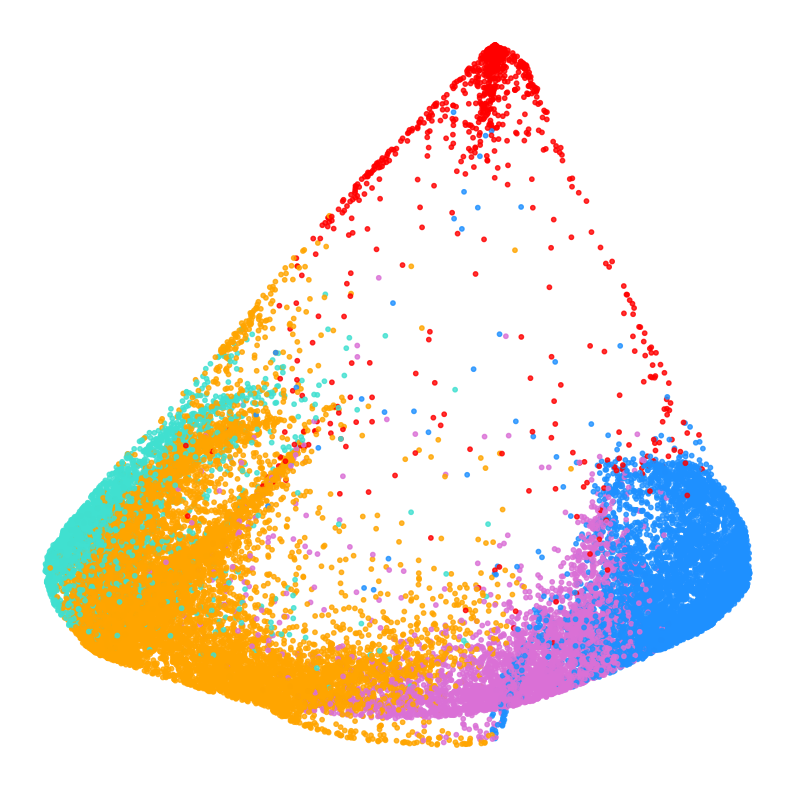

In [10]:
kwargs = {'s': 10,
            'alpha': 0.8,
            'rasterized': True,
          }

colors = adata.obs['phase_colors']
manifold.plot_phate_coords(adata = adata,
                           colors = colors,
                           kwargs = kwargs,)